# Entropies & Dimensions


Topics:
* Entropies from **DynamicalSystems.jl**
* Generalized Dimension
* Automated dimension estimation!
* Other related concepts
* Docstrings

---

# Generalized Entropy

* In the study of dynamical systems there are many quantities that identify as "entropy".
* These quantities are not the more commonly known [thermodynamic ones](https://en.wikipedia.org/wiki/Entropy), used in Statistical Physics. 
* Rather, they are more like the entropies of [information theory](https://en.wikipedia.org/wiki/Entropy_(information_theory), which represent information contained within a dataset. 
* In general, the more "uncertain" or "random" the dataset is, the larger its entropy will be. On the other hand, the lower the entropy, the more "predictable" the dataset becomes.


Let $p$ be an array of probabilities (such that it sums to 1). Then the generalized entropy is defined as 

$$
R_\alpha(p) = \frac{1}{1-\alpha}\log\left(\sum_i p[i]^\alpha\right)
$$

and is also called [Rényi entropy](https://en.wikipedia.org/wiki/R%C3%A9nyi_entropy). Other entropies, like e.g. the [Shannon entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory) are generalized by it, since for $\alpha = 1$, the Rényi entropy becomes the Shannon entropy,

$$
R_1(p) = -\left(\sum_i p[i] \log (p[i]) \right)
$$

The Rényi entropy can be computed for a specific dataset, given $p$. But how does one get $p$?
1. $p$ represents the probability that a point of a dataset falls into a specific "bin". 
2. It is nothing more than the (normalized) histogram of the dataset!

In [52]:
using DynamicalSystems

Let's generate a dataset so that we can practice calculating entropies.

In [53]:
N = 100000
randomdata = Dataset(rand(N,3))

3-dimensional Dataset{Float64} with 100000 points
 0.748244   0.22896    0.911994
 0.938412   0.461608   0.92072 
 0.543664   0.637526   0.449897
 0.437051   0.410596   0.615079
 0.291084   0.944725   0.781869
 0.339147   0.759416   0.973281
 0.865328   0.838523   0.150525
 0.919007   0.451689   0.513249
 0.292374   0.024548   0.868366
 0.244673   0.373569   0.101827
 0.0375189  0.646712   0.622049
 0.849457   0.867411   0.850035
 0.419948   0.578105   0.860869
 ⋮                             
 0.464328   0.293143   0.430965
 0.18367    0.379628   0.861446
 0.483306   0.0830311  0.262124
 0.863597   0.592292   0.76599 
 0.508551   0.139351   0.238507
 0.796334   0.704294   0.861017
 0.0262872  0.488212   0.991447
 0.264067   0.785628   0.800286
 0.497464   0.82473    0.487972
 0.906668   0.709457   0.297275
 0.0686283  0.804324   0.261919
 0.257962   0.811167   0.142184


---

```julia
genentropy(α, ε, dataset::AbstractDataset; base = e)
```
* This function calculates the generalized entropy of order `α`.
* It first calculates the probability array $p$.
* The "histogram" is created by partitioning the `dataset` into boxes of size `ε`.


In [58]:
genentropy(2, 0.1, randomdata)

6.897719407233242

In [59]:
genentropy(2, 0.01, randomdata)

11.416343367123178

In [60]:
genentropy(2, 0.001, randomdata)

11.512885465769227

In [61]:
genentropy(2, 0.0001, randomdata)

11.512925464969248

Note that the output of `genentropy` changed with changing $\varepsilon$ until we hit $\varepsilon = 0.001$. 

At this point the value for the entropy has already saturated. There's no use in partitioning the dataset in smaller boxes.

---

Now let's calculate the entropy of a coin toss!

First, let's create an array, `y`, that stores the results of coin tosses as `0`s or `1`s for `1000000` tosses.

In [63]:
y = Float64.(rand(Bool, 1000000))

1000000-element Array{Float64,1}:
 0.0
 0.0
 1.0
 0.0
 1.0
 0.0
 1.0
 0.0
 1.0
 1.0
 1.0
 0.0
 0.0
 ⋮  
 0.0
 1.0
 1.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 1.0
 1.0
 0.0

In [64]:
sh = genentropy(1, 0.1, y) # Renyi entropy with α = 1 is the Shannon entropy

0.693146934157925

The above number should be log(2) [by definition](https://en.wikipedia.org/wiki/Shannon_(unit)

In [65]:
isapprox(sh, log(2), rtol = 1e-4)

true

`genentropy` is conveniently used with `trajectory` outputs.

Here we create a trajectory for a towel map,

In [71]:
towel = Systems.towel()
tr = trajectory(towel, N-1);
summary(tr)

"3-dimensional Dataset{Float64} with 100000 points"

and calculate its entropy:

In [72]:
genentropy(1, 0.01, tr) # The result is with log base-e !

9.47195269047054

Let's also compare the entropy of the above dataset (a trajectory of the towel map) with that of a random dataset:

In [73]:
genentropy(1, 0.01, randomdata)

11.444156175223966

* As expected, the entropy of the random dataset is higher.

---

How much time does the computation take?

In [74]:
using BenchmarkTools
@btime genentropy(1, 0.01, $tr);

  15.797 ms (42 allocations: 3.05 MiB)


## Specialized histogram
* Partitioning the dataset (i.e. generating a "histogram") is in general a costly operation that depends exponentially on the number of dimensions.
* In this specific application however, we can tremendously reduce the memory allocation and time spent!

Let's get the array of probabilities $p$ for size ε where `tr` is the trajectory of the towel map

In [75]:
ε = 0.01
p = non0hist(ε, tr)

19407-element Array{Float64,1}:
 1.0e-5 
 4.0e-5 
 2.0e-5 
 5.0e-5 
 1.0e-5 
 1.0e-5 
 7.0e-5 
 0.00015
 4.0e-5 
 5.0e-5 
 1.0e-5 
 7.0e-5 
 5.0e-5 
 ⋮      
 3.0e-5 
 5.0e-5 
 8.0e-5 
 1.0e-5 
 0.00013
 2.0e-5 
 2.0e-5 
 2.0e-5 
 0.00011
 1.0e-5 
 4.0e-5 
 2.0e-5 

Here's a sanity check, showing our probabilities should sum to roughly `1`.

In [76]:
sum(p)

0.9999999999999992

How long does generating the histogram take?

In [77]:
@btime non0hist($ε, $tr);

  15.580 ms (37 allocations: 3.05 MiB)


How long does this take if we create 9-dimensional data and compare again?

In [78]:
nine = Dataset(rand(N, 9))
@btime non0hist($ε, $nine);

  48.882 ms (44 allocations: 28.53 MiB)


* We went from dimension 3 to dimension 9 but the time roughly only tripled

# Attractor Dimension
1. There are numerous methods that one can use to calculate a so-called "dimension" of a
dataset, like for example the [Fractal dimension](https://en.wikipedia.org/wiki/Fractal_dimension).

2. Most of the time these dimensions indicate some kind of scaling behavior. 

3. For example, the scaling of `genentropy` with decreasing `ε` gives the so-called "generalized dimension".


$ E \approx -D\log(\varepsilon)$ with $E$ the entropy and $D$ the "dimension".

---
I want to know dimension of attractor of the Towel Map!



In [79]:
towel = Systems.towel()
towel_tr = trajectory(towel, 1000000);
summary(towel_tr)

"3-dimensional Dataset{Float64} with 1000001 points"

Note that more points = more precision = more computations = more time!

Now I want to compute `genentropy` for different ε.

Which ε should we use...?

Let's do a "random" logspace based guess...

In [80]:
ες = logspace(-4, 1, 12)

12-element Array{Float64,1}:
  0.0001     
  0.000284804
  0.000811131
  0.00231013 
  0.00657933 
  0.0187382  
  0.053367   
  0.151991   
  0.432876   
  1.23285    
  3.51119    
 10.0        

In [81]:
Es = zeros(ες)
for (i, ε) ∈ enumerate(ες)
    Es[i] = genentropy(1, ε, towel_tr)
end
Es

12-element Array{Float64,1}:
 13.8116 
 13.781  
 13.5601 
 12.5477 
 10.4825 
  8.23824
  6.05165
  3.7852 
  1.6531 
 -0.0    
 -0.0    
 -0.0    

**Shorter version:**

In [82]:
Es = genentropy.(1, ες, towel_tr)

12-element Array{Float64,1}:
 13.8116 
 13.781  
 13.5601 
 12.5477 
 10.4825 
  8.23824
  6.05165
  3.7852 
  1.6531 
 -0.0    
 -0.0    
 -0.0    

Alright. Remember that it should be that $E \approx -D\log(\varepsilon)$
 with $E$ the entropy and $D$ the "dimension". 

Let's plot and see:

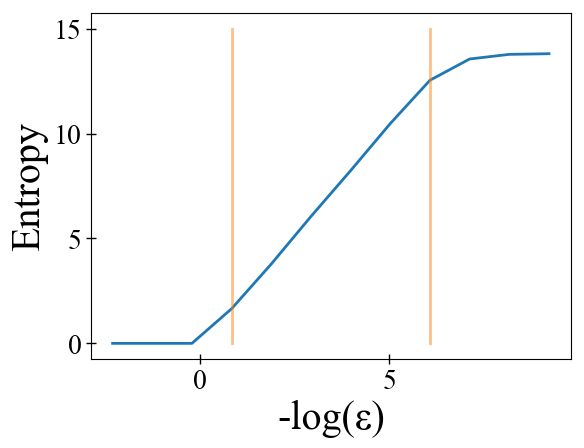

In [83]:
using PyPlot; figure(figsize = (6,4))
x = -log.(ες)
plot(x, Es); xlabel("-log(ε)"); ylabel("Entropy");
plot([x[4], x[4]], [0, 15], color = "C1", alpha = 0.5)
plot([x[end-3], x[end-3]], [0, 15], color = "C1", alpha = 0.5);

What typically happens is that there is some region where this scaling behavior holds, but then it stops holding due to the finite amount of data points.

Above, the expected scaling behavior holds between the orange vertical lines.

Let's choose the curve points that do fall in the linear regime of the above plot,

In [84]:
x, y = -log.(ες)[4:end-2], Es[4:end-2]

([6.07045, 5.02382, 3.97719, 2.93056, 1.88393, 0.837304, -0.209326], [12.5477, 10.4825, 8.23824, 6.05165, 3.7852, 1.6531, -0.0])

and find the slope of the curve there, to calculate the dimension, D.

In [85]:
offset, slope = linreg(x, y)
D = slope

2.03902652552714

This is actually a correct result, the information dimension of the attractor of the towel map is around 2.

---

* Are the values of `ες` we used good? 
* For a general dataset, how can we determine them?

the function `estimate_boxsizes(dataset; kwargs...)` can help with that!

In [91]:
ες = estimate_boxsizes(towel_tr)

12-element Array{Float64,1}:
 0.0001     
 0.000187382
 0.000351119
 0.000657933
 0.00123285 
 0.00231013 
 0.00432876 
 0.00811131 
 0.0151991  
 0.0284804  
 0.053367   
 0.1        

Let's plot $E$ vs. $-\log \epsilon$ again

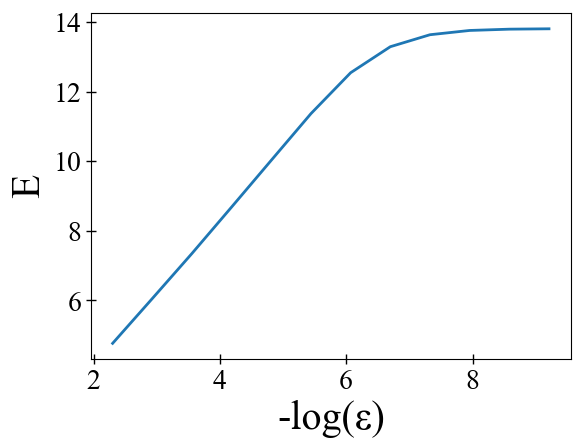

In [92]:
Es = genentropy.(1, ες, towel_tr)
figure(figsize = (6,4))
plot(-log.(ες), Es); xlabel("-log(ε)"); ylabel("E");

---
# Automated Dimension Estimation

Given some arbitrary plot like the one above, is there any algorithm to deduce a scaling region???

The function `linear_regions(x, y; kwargs...)` decomposes the function `y(x)` into regions where  the function is linear.

It returns the indices of `x` that correspond to linear regions and the approximated tangents at each region!

In [93]:
x = -log.(ες)
lrs, slopes = linear_regions(x, Es)

([1, 2, 3, 4, 5, 6, 12], [0.0169754, 0.059061, 0.195576, 0.549296, 1.19167, 1.87214])

In [94]:
for i in 1:length(slopes)
    println("linear region $(i) starts from index $(lrs[i]) and ends at index $(lrs[i+1])")
    println("with corresponding slope $(slopes[i])")
    println()
end

linear region 1 starts from index 1 and ends at index 2
with corresponding slope 0.01697540475919078

linear region 2 starts from index 2 and ends at index 3
with corresponding slope 0.059060992416266674

linear region 3 starts from index 3 and ends at index 4
with corresponding slope 0.19557558745055342

linear region 4 starts from index 4 and ends at index 5
with corresponding slope 0.5492959963318305

linear region 5 starts from index 5 and ends at index 6
with corresponding slope 1.1916713297590442

linear region 6 starts from index 6 and ends at index 12
with corresponding slope 1.8721371361939052



The linear region which is biggest is "probably correct one".
Here the last linear region is the largest; thus the slope is

In [29]:
slopes[end]

1.8721371361939052

This `linear_regions` function seems very shady... Is there any "easy" way to visualize what it does? *Say no more!*

In this next example, we'll use `ChaosTools`, which belows to `DynamicalSystems`.

In [95]:
using PyPlot, ChaosTools

`ChaosTools` provides a function, `plot_linear_regions` !

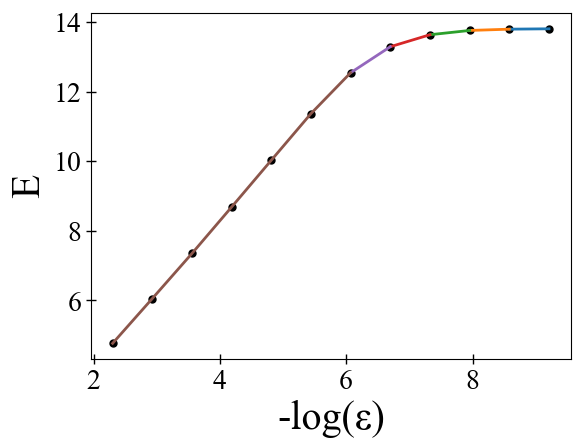

In [96]:
figure(figsize=(6,4))
plot_linear_regions(x, Es)
xlabel("-log(ε)"); ylabel("E");

Adjust the tolerance of `linear_regions` using keyword argument `tol`

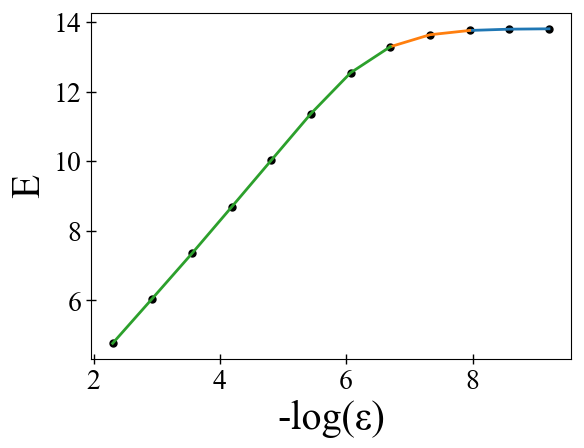

In [97]:
figure(figsize=(6,4))
plot_linear_regions(x, Es; tol = 0.8)
xlabel("-log(ε)"); ylabel("E");

Notice how the color schemes allow us to visualize that adjusting the tolerance reduces our number of linear regimes!

## `generalized_dim` function

Let's summarize what we just did to estimate the dimension of an attractor.

1. We decided on some partition sizes `ες` to use (the function `estimate_boxsizes` can give an estimate for that).
2. For each `ε` in `ες` we calculated the entropy via `genentropy`. We stored these entropies in an array `Es`.
3. We tried to find a "linear scaling region" of the curve `Es` vs. `-log.(ες)`.
4. The slope of this "linear scaling region" is the dimension we estimated.

Wouldn't it be **cool** if all of this process could happen with one function call?

This is *exactly* what the following function does:
```julia
generalized_dim(α, dataset, ες = estimate_boxsizes(tr))
```
which computes the `α`-order generalized dimension.

In [98]:
generalized_dim(2.0, tr)

1.9120149473639927

In [99]:
generalized_dim(1.0, tr)

2.045143523958735

The first input to `generalized_dim` is our value for $\alpha$!

Similarly, let's calculate the dimension of the Henon map that we have seen in previous tutorials,

In [35]:
hen = Systems.henon()
tr = trajectory(hen, 200000)
generalized_dim(0, tr)

1.2192730981829056

and of the Lorenz system:

In [100]:
lor = Systems.lorenz()
tr_lor = trajectory(lor, 1000.0; dt = 0.05);

In [101]:
generalized_dim(2.0, tr_lor)

1.9899579669996978

The correlation dimension of the Lorenz attractor (for default parameters) is reported *somewhere* around `2.0` (Grassberger and Procaccia, 1983).

## `generalized_dim` is but a crude estimate!

**It is important to understand that `generalized_dim` is only a crude estimate! You must check and double-check and triple-check if you want more accuracy!**

# Other related concepts
## Kaplan-Yorke dimension
The Kaplan-Yorke dimension is defined as simply the (interpolated) number where the sum of Lyapunov exponents crosses zero.

This simple interpolation is done by the function `kaplanyorke_dim(ls)`.

In [42]:
lor = Systems.lorenz()

ls = lyapunovs(lor, 4000.0; Ttr = 100.0)

3-element Array{Float64,1}:
   0.900914  
  -8.89309e-5
 -14.5675    

In [43]:
kaplanyorke_dim(ls)

2.0618380242828573

## Permutation Entropy

Another entropy-like quantity that you can compute with **DynamicalSystems.jl** is the [permutation entropy](https://juliadynamics.github.io/DynamicalSystems.jl/latest/chaos/entropies/#permutation-entropy).

This is done with the function `permentropy(s, order; ...)`. The permutation entropy is different because it requires a *timeseries* `s` as the input. 

In [44]:
# create timeseries:
s = (ds = Systems.towel(); trajectory(towel, 10000)[:, 1])
# order `o` permutation entropy:
o = 6
permentropy(s, o)

3.600068724233908

# Docstrings

In [45]:
?genentropy

search: genentropy



```
genentropy(α, ε, dataset::AbstractDataset; base = e)
```

Compute the `α` order generalized (Rényi) entropy [1] of a dataset, by first partitioning it into boxes of length `ε` using [`non0hist`](@ref).

```julia
genentropy(α, p::AbstractArray; base = e)
```

Compute the entropy of an array `p` directly, assuming that `p` is sum-normalized.

Optionally use `base` for the logarithms.

## Description

Let $p$ be an array of probabilities (summing to 1). Then the Rényi entropy is

$$
R_\alpha(p) = \frac{1}{1-\alpha} \log \left(\sum_i p[i]^\alpha\right)
$$

and generalizes other known entropies, like e.g. the information entropy ($\alpha = 1$, see [2]), the maximum entropy ($\alpha=0$, also known as Hartley entropy), or the correlation entropy ($\alpha = 2$, also known as collision entropy).

## References

[1] : A. Rényi, *Proceedings of the fourth Berkeley Symposium on Mathematics, Statistics and Probability*, pp 547 (1960)

[2] : C. E. Shannon, Bell Systems Technical Journal **27**, pp 379 (1948)


In [46]:
?generalized_dim

search: generalized_dim



```
generalized_dim(α, dataset [, sizes]) -> D_α
```

Return the `α` order generalized dimension of the `dataset`, by calculating the [`genentropy`](@ref) for each `ε ∈ sizes`.

## Description

The returned dimension is approximated by the (inverse) power law exponent of the scaling of the [`genentropy`](@ref) versus the box size `ε`, where `ε ∈ sizes`.

Calling this function performs a lot of automated steps:

1. A vector of box sizes is decided by calling `sizes = estimate_boxsizes(dataset)`, if `sizes` is not given.
2. For each element of `sizes` the appropriate entropy is calculated, through `d = genentropy.(α, sizes, dataset)`. Let `x = -log.(sizes)`.
3. The curve `d(x)` is decomposed into linear regions, using [`linear_regions`](@ref)`(x, d)`.
4. The biggest linear region is chosen, and a fit for the slope of that region is performed using the function [`linear_region`](@ref). This slope is the return value of `generalized_dim`.

By doing these steps one by one yourself, you can adjust the keyword arguments given to each of these function calls, refining the accuracy of the result.

The following aliases are provided:

  * α = 0 : `boxcounting_dim`, `capacity_dim`
  * α = 1 : `information_dim`


In [47]:
?non0hist

search: non0hist



```julia
non0hist(ε, dataset::AbstractDataset)
```

Partition a dataset into tabulated intervals (boxes) of size `ε` and return the sum-normalized histogram in an unordered 1D form, discarding all zero elements.

## Performances Notes

This method is effecient in both memory and speed, because it uses a dictionary to collect the information of bins with elements, while it completely disregards empty bins. This allows computation of entropies of high-dimensional datasets and with small box sizes `ε` without memory overflow.

Use e.g. `fit(Histogram, ...)` from [`StatsBase`](http://juliastats.github.io/StatsBase.jl/stable/) if you wish to keep information about the edges of the binning as well as the zero elements.


In [48]:
?estimate_boxsizes

search: estimate_boxsizes



```
estimate_boxsizes(dataset::AbstractDataset; k::Int = 12, z = -1, w = 1)
```

Return a `k`-element `logspace` from `lower + w` to `upper + z`,

`lower` is the magnitude of the minimum pair-wise distance between datapoints while `upper` is the magnitude of the maximum difference between greatest and smallest number among each timeseries.

"Magnitude" here stands for order of magnitude, i.e. `round(log10(x))`.


In [49]:
?linear_regions

search: linear_regions plot_linear_regions linear_region



```
linear_regions(x, y; dxi::Int = 1, tol = 0.2) -> (lrs, tangents)
```

Identify regions where the curve `y(x)` is linear, by scanning the `x`-axis every `dxi` indices (e.g. at `x[1] to x[5], x[5] to x[10], x[10] to x[15]` and so on if `dxi=5`).

If the slope (calculated using `LsqFit`) of a region of width `dxi` is approximatelly equal to that of the previous region, within tolerance `tol`, then these two regions belong to the same linear region.

Return the indices of `x` that correspond to linear regions, `lrs`, and the approximated `tangents` at each region. `lrs` is a vector of `Int`.

A function `plot_linear_regions` visualizes the result of using this `linear_regions` (requires `PyPlot`).


In [50]:
?kaplanyorke_dim

search: kaplanyorke_dim



```
kaplanyorke_dim(lyapunovs::AbstractVector)
```

Calculate the Kaplan-Yorke dimension, a.k.a. Lyapunov dimension [1].

## Description

The Kaplan-Yorke dimension is simply the point where `cumsum(lyapunovs)` becomes zero (interpolated). If the sum of the exponents never becomes negative the function will return the length of the input vector.

Useful in combination with [`lyapunovs`](@ref).

## References

[1] :  J. Kaplan & J. Yorke, *Chaotic behavior of multidimensional difference equations*, Lecture Notes in Mathematics vol. **730**, Springer (1979)


In [51]:
?permentropy

search: permentropy



```
permentropy(x::AbstractVector, order [, interval=1]; base = e)
```

Compute the permutation entropy [1] of given `order` from the `x` timeseries.

Optionally, `interval` can be specified to use `x[t0:interval:t1]` when calculating permutation of the sliding windows between `t0` and `t1 = t0 + interval * (order - 1)`.

Optionally use `base` for the logarithms.

## References

[1] : C. Bandt, & B. Pompe, [Phys. Rev. Lett. **88** (17), pp 174102 (2002)](http://doi.org/10.1103/PhysRevLett.88.174102)
